# Introduzione

L'obiettivo è quello di analizzare il dataset sui funghi, e testare diversi classificatori per trovare il migliore nel classificare nuovi funghi come commestibili o velenosi. Il documento è composto come segue:

- Data Exploration
    - Analisi classi dataset
    - Feature Selection
    - Rimozione righe malformate
- Test Classificatori
    - Naive Bayes
    - Random Forest
    - ...
    - ...

Import delle librerie necessarie

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold

#altri import futuri

Caricamento del dataset

In [76]:
df = pd.read_csv("dataset/secondary_data.csv", sep=";")
print("Dimension:", df.shape)
df.head()

Dimension: (61069, 21)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


# Data Exploration

Visualizzazione campi non nulli per ogni colonna/feature del dataset. Questo ci serve per vedere eventuali colonne che possono poi essere rimosse

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

## Class Balancing
Siamo interessati a classificare i funghi come velenosi o meno, per questo motivo identifichiamo le due classi di interesse a partire dalla colonna "class" del dataset. Vogliamo vedere quanto sono bilanciate le classi del dataset

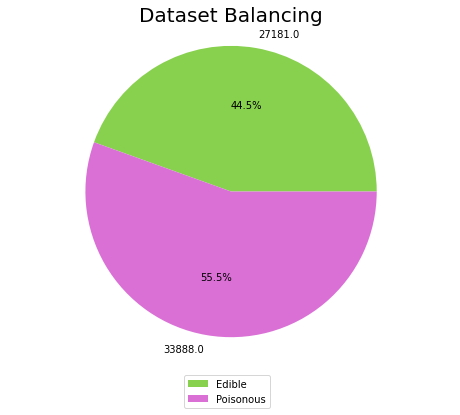

In [78]:
classes = [{"Commestibili": (df["class"] == "e").sum(), "Velenosi": (df["class"] == "p").sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Commestibili"])
total_p = float(total["Velenosi"])
mushrooms = [total_e, total_p]
mushrooms_labels = 'Edible','Poisonous'
fig, ax = plt.subplots(figsize = (8,6))
plt.pie(mushrooms,labels=mushrooms,autopct='%1.1f%%',colors = ['#88d14f', '#DA70D6'])
plt.title('Dataset Balancing', loc = "center", fontsize="20")
plt.axis('equal')
plt.legend(mushrooms_labels,bbox_to_anchor=(0.6, -0.05, 0, 0))
fig.set_facecolor('white')
plt.show()

Vediamo che ci sono in percetuale il 10% in più di funghi velenosi, e questo può portare il classificatore a tendere nel classificare funghi come velenosi (falso positivo). Questo errore è meno grave del falso negativo (perche se ti dico che un fungo è velenoso comunque non lo mangi, il contrario invece è velenoso ti dico di no e muori). 

Possiamo pensare di ribilanciare le classi tramite oversampling o undersampling, oppure ancora meglio con SMOTE.

Rivalutare magari il class balancing dopo rimozione delle righe con valori nulli.

## Feature Visualization

Visualizziamo il numero di classi per ogni feature in modo da visualizzare possibili colonne da rimuovere perche con valori costanti o quasi.

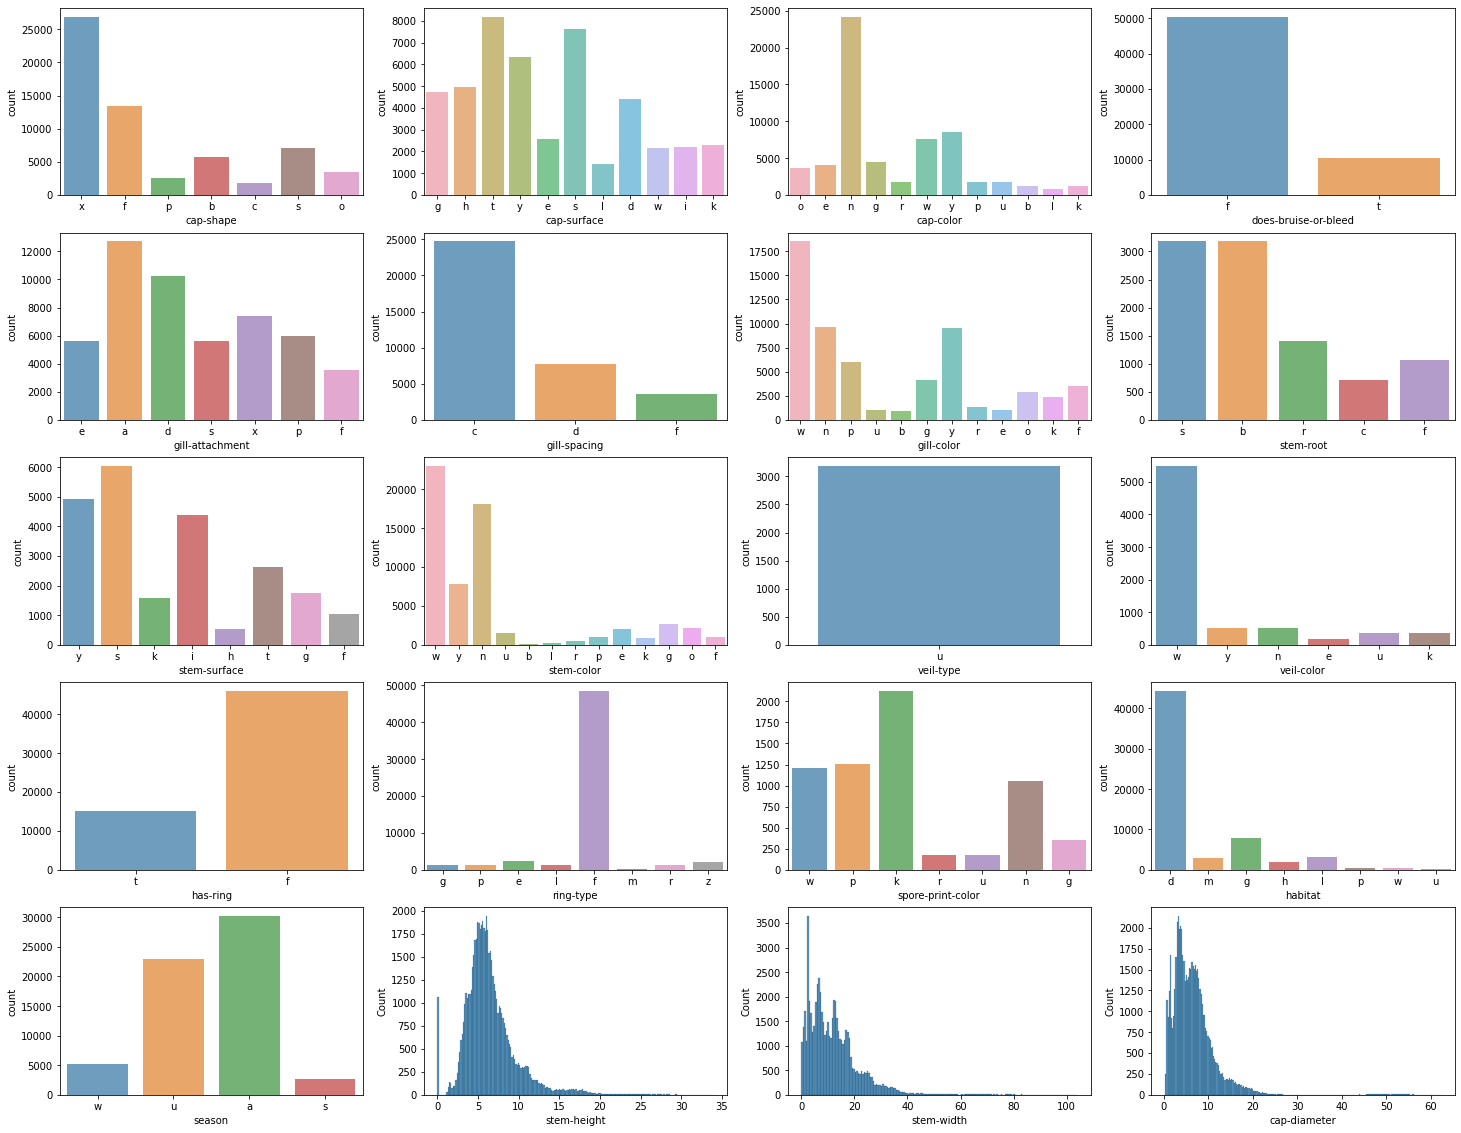

In [79]:
categ =  [ 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
conti = ['stem-height', 'stem-width', 'cap-diameter']
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']

fig = plt.figure(figsize=(25,20))
for i in range(0, len(categ)):
    fig.add_subplot(5,4,i+1)
    sns.countplot(x=categ[i], data=df, alpha=.7) 

for col in conti:
    fig.add_subplot(5,4,i+2)
    i+=1
    sns.histplot(df[col].dropna(), kde_kws={"lw": 2, "color":colors[8]})

Analizzando la distribuzione delle varie features è evidente che la feature ```veil-type``` possa essere rimossa dall'insieme delle features. Questo perché presenta soltanto 3177 valori non nulli, e di valore costante ```u```.

In [80]:
df = df.drop(columns = "veil-type")

## Conversione Features e Mapping

Conversione delle features categoriche in nominali, si modifica prima il tipo di dato dei valori delle features da 'object' in 'category' per poi procedere con l'effettiva trasformazione dei valori categorici.

Si trasformano i valori categorici in numerici (int64) e si salva il dizionario che mantiene il mapping per un eventuale utilizzo futuro.

In [81]:
class LabelEncoderByCol(BaseEstimator, TransformerMixin):
    def __init__(self,col):
        self.col = col
        self.encoders = {}
        self.mapping = []
        for el in self.col:
            self.encoders[el] = LabelEncoder()
            
    def fit(self,x,y=None):
        x[self.col] = x[self.col].fillna('NaN')
        for el in self.col:
            a = x[el][x[el]!='NaN']
            self.encoders[el].fit(a)
        return self

    def transform(self,x,y=None):
        x[self.col] = x[self.col].fillna('NaN')
        for el in self.col:
            if (x[el].dtype == "object") :
                a = x[el][x[el]!='NaN']
                b = x[el].to_numpy()
                b[b!='NaN'] = self.encoders[el].transform(a)
                x[el]=b
                mapping_dict = {index : label for index , label in enumerate(self.encoders[el].classes_)}
                self.mapping.append(mapping_dict)
        return x

In [82]:
encoder = LabelEncoderByCol(df.columns)
encoder.fit(df)
mapped_dataset = encoder.transform(df)

Completiamo trasformando il tipo di dato associato alle features categoriche da 'object' in 'Int64', oggetto che accetta valori interi nulli.

In [83]:
for el in mapped_dataset.columns:
    if (mapped_dataset[el].dtype == "object"):
        mapped_dataset[el] = np.floor(pd.to_numeric(mapped_dataset[el], errors='coerce')).astype('Int64')

Vediamo che abbiamo mappato le nostre variabili categoriche in variabili ordinali. I valori nulli sono stati mantenuti <NaN> per una successiva fase di imputazione. 

In [84]:
mapped_dataset.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,1,15.26,6,2,6,0,2,<NA>,10,16.95,17.09,4,7,11,4,1,2,<NA>,0,3
1,1,16.60,6,2,6,0,2,<NA>,10,17.99,18.19,4,7,11,4,1,2,<NA>,0,2
2,1,14.07,6,2,6,0,2,<NA>,10,17.80,17.74,4,7,11,4,1,2,<NA>,0,3
3,1,14.17,2,3,1,0,2,<NA>,10,15.77,15.98,4,7,11,4,1,5,<NA>,0,3
4,1,14.64,6,3,6,0,2,<NA>,10,16.53,17.20,4,7,11,4,1,5,<NA>,0,3


## Feature Correlation

Vediamo il grado di correlazione reciproco tra le varie feature, compresa la correlazione di ogni feature con il target. In generale vogliamo che una feature sia altamente correlata con il target (quindi che il suo valore sia importante per discriminare se il fungo è positivo o negativo). Una correlazione alta è sia positiva (aumento del valore di uno aumenta il valore dell'altro) che negativa (aumento del valore di uno diminuisce il valore dell'altro). Una correlazione vicina allo zero implica che le variabili sono indipendenti tra loro.

In [85]:
mapped_dataset.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,1,15.26,6,2,6,0,2,<NA>,10,16.95,17.09,4,7,11,4,1,2,<NA>,0,3
1,1,16.60,6,2,6,0,2,<NA>,10,17.99,18.19,4,7,11,4,1,2,<NA>,0,2
2,1,14.07,6,2,6,0,2,<NA>,10,17.80,17.74,4,7,11,4,1,2,<NA>,0,3
3,1,14.17,2,3,1,0,2,<NA>,10,15.77,15.98,4,7,11,4,1,5,<NA>,0,3
4,1,14.64,6,3,6,0,2,<NA>,10,16.53,17.20,4,7,11,4,1,5,<NA>,0,3


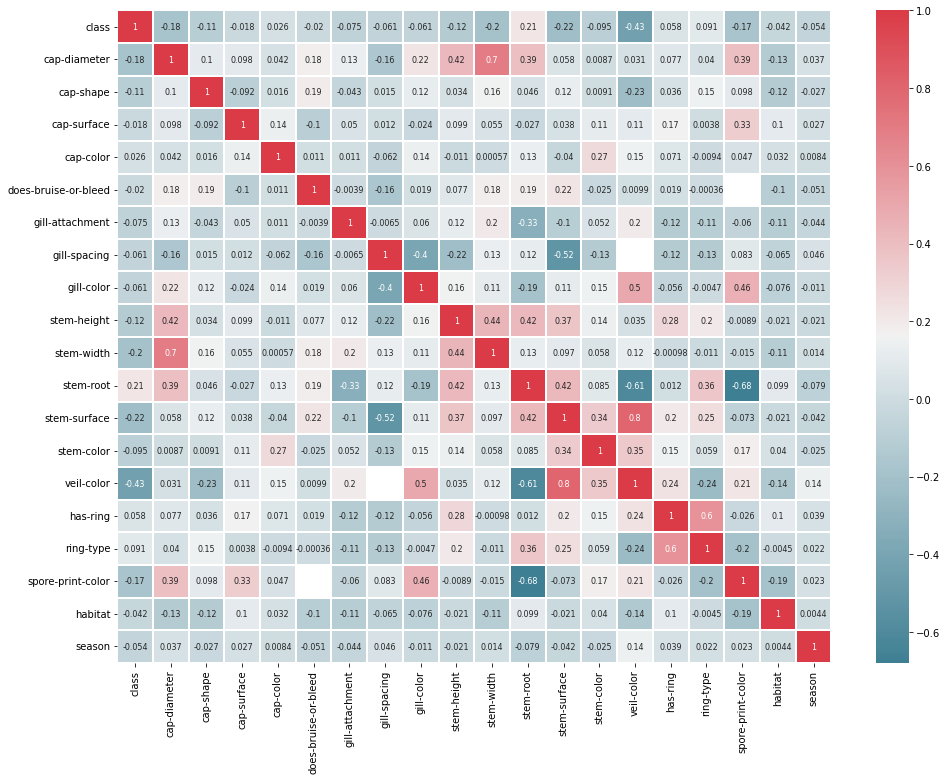

In [86]:
plt.figure(figsize=(16,12))
sns.heatmap(mapped_dataset.corr(), linewidths=.1, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, annot_kws={"size": 8})
plt.yticks(rotation=0)
plt.show()

## Feature Selection

Si selezionano le feature più utili ai fini della classificazione

### Rimozione di features con dati costanti

Primo approccio base di feature selection andiamo a rimuovere le feature con varianza nulla presenti nel df, ovvero quelle features il cui valore è costante.   
Dalla fase di Data Visualization abbiamo notato che una features con varianza nulla è il veil-type.
 
Applicando una Variance Threshold pari al 20% vengono rimosse le features ```does-bruise-or-bleed``` e ```has-ring```  
  
TODO rivalutare dopo se abbassandola migliora la classificazione 

In [89]:
selector = VarianceThreshold(0.2)
selector.fit(mapped_dataset)
mapped_dataset = mapped_dataset.loc[:, selector.get_support()]    # get_support() effettua la transform e ritorna l'indice delle colonne rimosse

mapped_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   class              61069 non-null  Int64  
 1   cap-diameter       61069 non-null  float64
 2   cap-shape          61069 non-null  Int64  
 3   cap-surface        46949 non-null  Int64  
 4   cap-color          61069 non-null  Int64  
 5   gill-attachment    51185 non-null  Int64  
 6   gill-spacing       36006 non-null  Int64  
 7   gill-color         61069 non-null  Int64  
 8   stem-height        61069 non-null  float64
 9   stem-width         61069 non-null  float64
 10  stem-root          9531 non-null   Int64  
 11  stem-surface       22945 non-null  Int64  
 12  stem-color         61069 non-null  Int64  
 13  veil-color         7413 non-null   Int64  
 14  ring-type          58598 non-null  Int64  
 15  spore-print-color  6354 non-null   Int64  
 16  habitat            610

### Rimozione di features con valori nulli

Si cancellano le features che presentano più del 50% di valori nulli. Per le colonne con meno del 50% di valori nulli si utilizza invece un meccanismo di imputazione per sopperire alla presenza di dati mancanti in quelle features da scartare ma che hanno buona correlazione (vd. dopo) con la variabile target e buona distribuzione dei valori.

In [90]:
# TODO cap-surface,14120 | gill-attachment,9884 | gill-spacing,25063 | stem-surface,38124 | ring-type,2471
mapped_dataset = mapped_dataset.drop(columns=["veil-color", "spore-print-color", "stem-root", "stem-surface"])
mapped_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   class            61069 non-null  Int64  
 1   cap-diameter     61069 non-null  float64
 2   cap-shape        61069 non-null  Int64  
 3   cap-surface      46949 non-null  Int64  
 4   cap-color        61069 non-null  Int64  
 5   gill-attachment  51185 non-null  Int64  
 6   gill-spacing     36006 non-null  Int64  
 7   gill-color       61069 non-null  Int64  
 8   stem-height      61069 non-null  float64
 9   stem-width       61069 non-null  float64
 10  stem-color       61069 non-null  Int64  
 11  ring-type        58598 non-null  Int64  
 12  habitat          61069 non-null  Int64  
 13  season           61069 non-null  Int64  
dtypes: Int64(11), float64(3)
memory usage: 7.2 MB


## Imputazione delle features con valori nulli

Si utilizza un meccanismo di imputazione per sopperire alla presenza di dati mancanti per le features da scartare per la politica scelta (nan < 50%), ma che presentano una buona correlazione con la variabile target e una buona distribuzione dei valori.
Ovviamente il meccanismo è applicato anche a quelle features con meno del 20% di valori nulli, così da ripristinare la variabile per l'uso nella classificazione rimpiazzando tutti i dati mancanti.

In [91]:
imp = KNNImputer(n_neighbors=1, weights='uniform')
imputedDataset = pd.DataFrame(imp.fit_transform(mapped_dataset), columns = mapped_dataset.columns)

KeyError: 7

Di seguito possiamo visualizzare come, tramite il kNN, i valori nulli delle features ```cap-surface```, ```ring-type```, ```gill-spacing``` e ```gill-attachment``` vengano ridistribuiti nelle varie classi

In [105]:
for col in imputedDataset:
    imputedDataset.co
# fig = plt.figure(figsize=(25,20))
# i = 0

# print(imputedDataset.info())
# for col in imputedDataset:
#     if (imputedDataset[col].dtype == "float64"):
#         print(col)
#         fig.add_subplot(5,4,i+1)
#         i+=1
#         sns.histplot(imputedDataset[col].dropna(), kde_kws={"lw": 2, "color":colors[8]})


KeyError: "None of [Float64Index([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,\n              ...\n              1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],\n             dtype='float64', length=61069)] are in the [columns]"